<a href="https://colab.research.google.com/github/ankurmahesh/ai4ess-hackathon-2020/blob/amahesh/notebooks/Seasonal_Forecasting_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was made by Ankur Mahesh.  Please email mahesh.ankur10@gmail.com if you have any questions!!


In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
!pip install netCDF4


In [ ]:
#Download the data that we will use for this tutorial
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

--2020-01-12 08:06:46--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2020-01-12 08:06:47--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc.1’

sst.mon.mean.trefad 100%[===================>] 412.45M  18.9MB/s    in 23s     

2020-01-12 08:07:10 (17.9 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc.1’ saved [432481041/432481041]

--2020

# Introduction
Welcome to the hackathon!  In this section of the hackathon, we will be forecasting El Nino with machine learning, and we will explore various machine learning problems along the way.  

Here are two recent papers that were successful in forecasting El Niño with machine learning ([here](https://www.nature.com/articles/s41586-019-1559-7) and [here](https://www.climatechange.ai/CameraReadySubmissions%202-119/119/CameraReadySubmission/Forecasting_El_Nino_with_Convolutional_and_Recurrent_Neural_Networks(1).pdf)).  We will explore a number of machine learning questions, including


*   hyperparameter tuning
*   classification vs. regression
*   model selection: convolutional neural networks vs. hybrid convolutional and recurrent neural networks
*   interpretability
*   benchmarking with traditional (i.e. non-deep learning) machine learning algorithms
*   data preparation
*   more data 

This is the second notebook in a series. It is **strongly** recommended that you first complete the Fundamentals of Machine Learning Colab notebook available [here](https://https://colab.research.google.com/drive/1Qo4JD3hQF9V2f0na2JOQ5XbsL_uiS7Kl#offline=true&sandboxMode=true).  Even if you are an expert, this notebook also uses the ENSO dataset and goes over important topics (How do you properly divide data into a train set and a test set? What is overfitting?  What is bias and variance?) that will assist you with this notebook. 





## THE HACKATHON TASK: ENSO FORECASTING
Background:  El Niño/ Southern Oscillation (ENSO) is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  We will train a neural network to forecast the Niño3.4 index at various lead times.  We will also explore and benchmark the use of other machine learning techniques, and we will explore the benefit of ensembling.

We will develop machine learning models to forecast ENSO.  There are two common metrics for measuring the performance of ML models for this task: RMSE (root-mean-squared error) and correlation.

Some terms:
*   predictor     : the input to a machine learning model: a certain number of months (that you define) of gridded temperature)
*   predictand    : the true value the model is trying to predict (i.e. the true Niño3.4 index)
*   prediction    : the output of the machine learning model

Let's get started: first, let's load the data.  **PLEASE READ THE DOCSTRING FOR THE `assemble_predictors_predictands` function!** It is essential to understand the arguments to this function as we explore different scientific/ machine learning questions later on in this hackathon.

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date 
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an 
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each 
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use 
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("In EXERCISE 7, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("In EXERCISE 7, you must implement the slicing!")
  
  
  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)
    

    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead, 
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X, y


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

**IMPORTANT info about `num_input_time_steps`:** `num_input_time_steps` refers to the number of time steps for each predictor.  For example, if `num_input_time_steps` is set to 3, then the machine learning model will take 3 months as its input.  In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)).  The predictand will be the Niño3.4 index `lead_time` months after March.

Let's define a simple convolutional neural network to start.  


# Exercise 1: Train A Simple Convolutional Neural Network to Forecast ENSO


Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [ ]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()
        
        #ATTENTION EXERCISE 9: print out the dimension of the extracted features from 
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are 
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.  

**IMPORTANT** Reading through this method will help you understand each step in the process of training a neural network!

In [ ]:
def train_network(net, criterion, optimizer, trainloader, testloader, 
                  experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()
          
          #Save the model weights that have the best performance!
        

          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))
    
  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)
  
  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name)

train Set: Epoch 01. loss: 0.704704
test Set: Epoch 01. loss: 0.835668


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-pac

train Set: Epoch 02. loss: 0.583202
test Set: Epoch 02. loss: 0.642975
train Set: Epoch 03. loss: 0.392284
test Set: Epoch 03. loss: 0.526734
train Set: Epoch 04. loss: 0.292264
test Set: Epoch 04. loss: 0.434184
train Set: Epoch 05. loss: 0.242922
test Set: Epoch 05. loss: 0.526305
train Set: Epoch 06. loss: 0.202982
test Set: Epoch 06. loss: 0.463523
train Set: Epoch 07. loss: 0.166644
test Set: Epoch 07. loss: 0.399631
train Set: Epoch 08. loss: 0.190502
test Set: Epoch 08. loss: 0.507552
train Set: Epoch 09. loss: 0.184624
test Set: Epoch 09. loss: 0.385237
train Set: Epoch 10. loss: 0.217394
test Set: Epoch 10. loss: 0.462174
train Set: Epoch 11. loss: 0.174720
test Set: Epoch 11. loss: 0.405323
train Set: Epoch 12. loss: 0.155505
test Set: Epoch 12. loss: 0.517581
train Set: Epoch 13. loss: 0.114338
test Set: Epoch 13. loss: 0.579958
train Set: Epoch 14. loss: 0.129908
test Set: Epoch 14. loss: 0.947891
train Set: Epoch 15. loss: 0.115168
test Set: Epoch 15. loss: 1.231004
train 

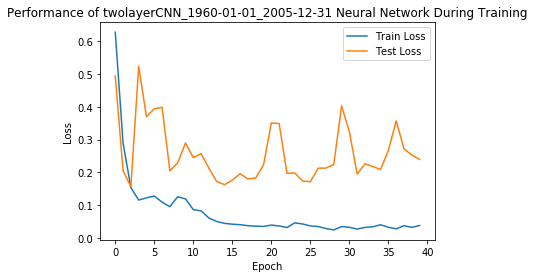

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

*Check your understanding:* From the previous notebook on fundamentals of machine learning, what is it called when the validation losses are very high and the train losses are very low?  What might we try to reduce this problem?

(Try reducing the number of parameters of the network -- see exercise 10!)

In [ ]:
def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    title                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


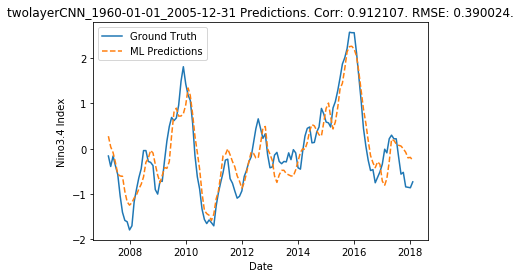

In [ ]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))

# Exercise 2: Forecast ENSO with Traditional Machine Learning using sklearn

Recall from the previous notebook that we used linear regression to forecast ENSO!  Try using other models for this task.  Explore the other models that sklearn has to offer, such as random forests!  Note: these traditional ML algorithms do not take advantage of the spatial nature of gridded datasets.  Therefore, they require the `data_format` argument to be set to 'flatten': the predictors are in the shape `(num_samples,lat*lon*num_time_steps)`.

**GOAL OF THIS EXERCISE:** try exploring the performance of other algorithms in the sklearn suite.  Try changing the lead_time in the `assemble_predictors_predictands` method (it is set to 1 initially).  How do the models perform?

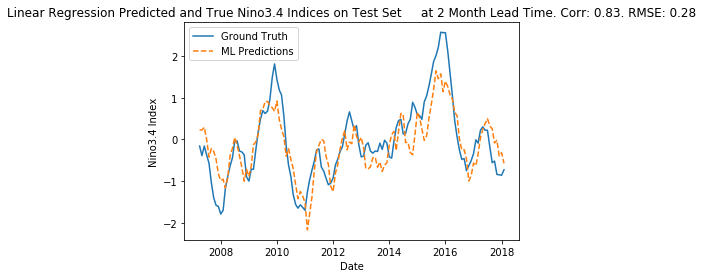

In [ ]:
"""Plot the performance of linear regression at 1 month ahead lead time"""
#1 month linear regression (lr) model
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

# Exercise 3: How does the quantity of data affect the performance of a machine learning algorithm?  

In the coding cell below, repeat the above training process for different length training datasets and test datasets!

**GOAL OF THIS EXERCISE**: train 6 neural networks: one on 10 years of data, one on 20 years of data, one on 30 years of data,...,one on 60 years of data.  Make a line plot showing the performance of each of these neural networks.  The X axis of the plot is the number of years of training data, and the y axis is the Pearson R value on the test set.

^Repeat the above for a traditional ML algorithm (e.g. linear regression) of your choice.

In [ ]:
for num_years in range(10,71,10):
  """YOUR CODE HERE"""
  pass

# Excercise 4: What data sources improve the ML algorithm? What data sources do not imprve the ML algorithm?

Let's try training our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset.  There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

**GOAL OF THIS EXERCISE**: generate two plots: one showing the time series of predicted and true Niño3.4 indices with an ML model trained on 1900-1930 data.  The other should show the same (time series of prediced and true Niño3.4 indices with a model trained on 1975-2005 data.  (Both trained algorithms should be tested on data from 2007-2018.)

In [ ]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
  """YOUR CODE HERE"""
  #Replicate the logic in the Exercise 1 and Exercise 2 to explore 
  #how well a CNN or traditional ML model does with the start 
  #and end dates defined above!  Plot the performance of the models!

# Exercise 5: Data wrangling: Do machine learning algorithms perform better with a classification problem or regression problem?

Convert the problem from regression (predicting a continuous value) to classification (predicting a discrete value).  In this case, the continuous value is the exact value of the Niño3.4 index.  

Let's bin the Niño3.4 index to two values: 0 and 1.  Let's say negative values of the Niño3.4 index should be mapped to 0 and positive values of the index should be mapped to 1.

### Goal of the exercise:

Train a neural network and an sklearn logistic regression model to predict 0 or 1 corresponding to the mapping above!  Try changing the neural network's loss function from `nn.MSELoss` to `nn.BCEWithLogitsLoss`!

In [ ]:
#1.Adjust the train_network method so that the target is always 0 or 1. Maybe add an
# argument called "classification" that takes in a boolean value indicating
# whether or not to map the target to 0 or 1.
#2. Change the loss function of the neural network
#3. Run the train_network method to get the neural network predictions
#4. You will have to write your own code to calculate the accuracy of these predictions!

# Exercise 6: GCMS!

In the deep learning for ENSO forecasting papers, the key breakthrough that allowed for state-of-the-art performance is that the algorithms were trained on global climate models (GCMs).  The availability of observed data is very limited.  With simulated data, neural networks are able to see more data and thus learn better.

## Goal for this exercise:

Train a neural network on data from GCMs.  The MPI GCM has data from the years 1850 to .  The CNRM GCM has data from the years .  Does more data help?  Does the increase in data make it possible to train on longer lead times?

In [ ]:
!wget http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/MPI_tas_anomalies_regridded.nc
!wget http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/CNRM_tas_anomalies_regridded.nc

--2020-01-12 08:51:56--  http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/MPI_tas_anomalies_regridded.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/MPI_tas_anomalies_regridded.nc [following]
--2020-01-12 08:51:57--  https://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/MPI_tas_anomalies_regridded.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220859592 (5.8G) [application/x-netcdf]
Saving to: ‘MPI_tas_anomalies_regridded.nc’

MPI_tas_anomalies_r 100%[===================>]   5.79G  19.2MB/s    in 5m 10s  

2020-01-12 08:57:08 (19.1 MB/s) - ‘MPI_tas_anomalies_regridded.nc’ saved [6220859592/6220859592]



In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1860-01-01'
train_end_date = '2100-12-31'
num_input_time_steps = 4
lead_time = 5
climate_model = 'MPI'


train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, climate_model, 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_MPI_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name,
                  num_epochs=10)

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning:

train Set: Epoch 01. loss: 0.498283
test Set: Epoch 01. loss: 0.600355
train Set: Epoch 02. loss: 0.244425
test Set: Epoch 02. loss: 0.554685
train Set: Epoch 03. loss: 0.189000
test Set: Epoch 03. loss: 0.549613
train Set: Epoch 04. loss: 0.157443
test Set: Epoch 04. loss: 0.563844
train Set: Epoch 05. loss: 0.135148
test Set: Epoch 05. loss: 0.594642
train Set: Epoch 06. loss: 0.116930
test Set: Epoch 06. loss: 0.637654
train Set: Epoch 07. loss: 0.102599
test Set: Epoch 07. loss: 0.705201
train Set: Epoch 08. loss: 0.091300
test Set: Epoch 08. loss: 0.778733
train Set: Epoch 09. loss: 0.081710
test Set: Epoch 09. loss: 0.867195
train Set: Epoch 10. loss: 0.080328
test Set: Epoch 10. loss: 0.932288
train Set: Epoch 11. loss: 0.105372
test Set: Epoch 11. loss: 0.749722


KeyboardInterrupt: ignored

2      0.094166
3      0.050656
4     -0.001544
5      0.070029
6      0.199787
         ...   
548   -0.696969
549   -0.613392
550   -0.523622
551   -0.487117
552   -0.530010
Length: 551, dtype: float64

# Exercise 7: Data Wrangling.  Should the predictors be the entire globe? Or just a specific region?

The Ham et. al. paper only uses Pacific temperatures to forecast the Niño3.4 index.  However, the Mahesh et. al. paper uses the entire globe.

Hypothesize which method you think might be better!  What assumptions does your hypothesis rely on?  Recall the bias-variance tradeoff that we discussed in the previous notebook!


*   Let's assume there is NO useful information for forecasting ENSO outside of the Pacific.  In other words, the rest of the world has no predictive power.  Would it make sense to use the entire globe as a predictor?  Discuss in the context of the bias-variance tradeoff.

The reality is probably mixed: the rest of the globe has some predictive power, but it also has noise!  Therefore, it's a tradeoff, because noisy inputs hurt model performance, but predictive inputs help performance!

## GOAL OF THIS EXERCISE

Check out slicing xarray datasets by latitude and longitude at this [link](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html).

Fill in the code in the `assemble_predictors_predictands` method for the slicing!

In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(-10, 10)
#Extract the following slice of longitude
lon_slice = slice(360-170,360-120)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)
rmse = mean_squared_error(predictions, test_predictands)
plot_nino_time_series(test_predictands, predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

Now, let's do a sanity check.  Let's change `lat_slice` and `lon_slice` to random regions, where it is unlikely there is any ENSO signal.  Let's observe the performance of the model!

In [ ]:
#Aassemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(-50, 40)
#Extract the following slice of longitude
lon_slice = slice(0,100)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)
rmse = mean_squared_error(predictions, test_predictands)
plot_nino_time_series(test_predictands, predictions,
    'Linear Regression Predicted (Using Nonsense Predictors) and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

NotImplementedError: ignored

#Excercise 8: Time Series of Gridded Monthly Temperature.  

Our inputs have so far have had 3 input months as each predictor, that is, `num_input_time_steps=3`.  Let's try changing this value and see how it affects the performance of our model!

**GOAL OF THIS EXERCISE:** Make a 2D matrix.  One axis denotes different values of `num_input_time_steps` . The other axis denotes different lead_times.  Plot the resulting matrix!

In [ ]:
for num_input_time_steps in range(1,7):
  for lead_time in range(1,5):
    experiment_name = "twolayerCNN_lead-{}_input-{}".format(num_input_time_steps, 
                                                            lead_time)
    """YOUR CODE HERE"""
    #Train and evaluate an ML algorithm of your choice on different
    #combinations of lead_time and num_input_time_steps.
    #Use plt.matshow to plot your results!

# Exercise 9: Get the best ENSO forecasting algorithm!  (Tip: check out ensembling between algorithms and try hyperparameter tuning.)

Do deeper neural networks with more convolutional layers help?
Try changing the hyperparameters of the neural network

*   learning rate
*   the choice of optimizer
*   the size of the convolution filters
*   the number of convolution filters
*   the number of weights in the fully connected layers

Does adding a time series of gridded monthly temperature as your predictor help?

Ensemble predictions from multiple different algorithms! Try using traditional ML, artificial neural networks, and convolutional neural networks.

Recall from the previous notebook: models with many parameters (i.e. very deep neural networks or very deep decision trees) are more likely to have very low bias and very high variance: they will likely overfit!

## Kaggle:

We will have a friendly competition.  *Develop a Nino3.4 Forecasting system for a lead_time of 5 months?* Submit your results to the kaggle link: https://www.kaggle.com/c/ams2020mlworkshop 

Details of the kaggle competition: just like in the first code cell, we will test our code on data from 2007-01-01 to 2017-12-31.  The data loader is reproduced below!  There are 131 predictor/predictand pairs between these dates.  Therefore, your entry should be exactly 131 numbers!  

In [ ]:
#Select the data parameters for your model(s)!
lead_time = 5
data_format = raise NotImplementedError("Select a data format for your kaggle entry!")
lat_slice = raise NotImplementedError("Select a lat slice for your kaggle entry!")
lon_slice = raise NotImplementedError("Select a lon slice for your kaggle entry!")
num_input_time_steps = 3 #Do not change this!
use_pca = raise NotImplementedError("You decide if you would like to use PCA on the input predictors!")
n_components = raise NotImplementedError("You decide how many principal components to use on the input predictors!")
train_predictors, train_predictands = """YOUR CODE HERE: assemble predictors predictands how you see fit"""

train_predictors, train_predictands = assemble_predictors_predictands('YOUR CHOICE OF START DATE',
                    'YOUR CHOICE OF END DATE', lead_time=5, dataset='observations', 
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)
#Do not change the line below for your kaggle submission
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations', 
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)

#If using deep learning:
# create an ENSODataset and DataLoader
#object (see code cell in Exercise 1) and use the `train_network` method to 
#extract predictions!
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
cnn_predictions, _, _ = train_network()


#If using regular traditional ML with sklearn:
sklearn_model = #choose sklearn model
sklearn_model.fit(train_predictors,train_predictands)

sklearn_predictions = sklearn_model.predict(test_predictors)


#Ensemble predictions from multiple algorithms
#(i.e. take the average of predictions from multiple algorithms!)
predictions = (cnn_predictions +sklearn_predictions)/2.0



SyntaxError: ignored

In [ ]:
#TO GENERATE A kaggle READY SUBMISSION:
import pandas as pd
submission_df = pd.DataFrame()
submission_df['Id'] = np.arange(130)
submission_df['Predicted'] = np.random.uniform(size=(130)) #replace with your predictions!
submission_df.to_csv('submission.csv',index=False)
from google.colab import files
files.download('submission.csv') 

## Tip when changing convolutional layers:

When you are changing the size of convolution filter windows, pay special attention to the comment starting with "ATTENTION EXERCISE 9" in the `CNN` class.  This is a  TOUGH part of designing neural networks, especially in climate data where data is of many different grids!!  And it automatically causes your code to break!

After the convolution layers, ["features"](https://deepai.org/machine-learning-glossary-and-terms/feature-extraction) have been extracted from the input image.  These features are not necessarily of the same dimension as the input, but these features are spatial (that is, they are of the shape (batch_size, num_input_channels, lat, lon).  

We want to map these features to the value of the Niño3.4 index.  To do this mapping, we need a Linear (fully connected layer).  This Linear layer performs a matrix multiplication between the extracted features from the convolution layers and the weights of the linear layer.  Thus, it must know the dimensions of the features ahead of time.

The "Print" layer prints out the dimension of the extracted features.  Thus, we can design the linear layer accordingly, since the Linear layer requires the dimension of the input in order to perform a matrix multiplication.  

Of course, it is also possible and preferred to calculate the dimensions of the extracted features, using the formulas [here](http://cs231n.github.io/convolutional-networks/#conv).  Using the "Print" layer is a hacky get-around!

# CHALLENGE EXERCISE 10: Do not just forecast ENSO.  Use this toolkit to forecast seasonal temperatures on land!

The machine learning framework we have developed here relies on assembling a set of predictors and predictands.  Thus far, the predictors have been surface temperature and the predictands have been the Nino3.4 index.  However, what if we wanted to forecast something else on seasonal time scales?  


In this section, please adjust the `assemble_predictors_predictands` methods to take into account ARBITRARY locations as predictors.  By default, the method uses the Nino3.4 Index.  Then, train a model to forecast temperature at regions you are interested in.

For the purpose of comparison, we will ask everyone to forecast temperature at these location at a lead time of 3 months:



*  Akron, Ohio: lat = 41, lon = 360-81
*  Mexico City, Mexico: lat = 19, lon = 360-99
*  Lima, Peru: lat = -12, 360-77


How does the forecasting performance change at these regions?

Feel free to test on any other regions you like and submit those as well.  We would love to the performance of your models at other regions as well.

In [1]:
"""YOUR CODE HERE"""

'YOUR CODE HERE'

#CHALLENGE EXERCISE 11: CNNs+LSTMs

If num_input_time_steps is greater than 1, then the model uses a time series of inputs to make its prediction.  Recurrent neural networks (with Long Short Term Memory (LSTM) architectures) are used for this purpose!  

**GOAL OF THIS EXERCISE:** Design a recurrent neural network (called an LSTM) for ENSO forecasting. For each input time step, 

1.   a CNN should extract features
2.   These features should then be fed into an LSTM

(The LSTM decides which parts of the features to remember and which to forget)

After the last input time step is fed into the LSTM, the model should use fully connected layers to make a forecast.

In [ ]:
class CNNandLSTM(nn.Module):
  """YOUR CODE HERE"""

In [ ]:
"""Use the logic above to create a train and test dataloader!  Evaluate your CNN+LSTM!"""

'Use the logic above to create a train and test dataloader!  Evaluate your CNN+LSTM!'

# BONUS FUN EXERCISE (for numpy enthusiasts): 

In the `assemble_predictors_predictands` method, there is a comment starting with "#CHALLENGE:".  Can you implement the line above without using a `for` loop? (An implementation without a `for loop` is called a vectorized implementation, and it increases the speed.)

This is the line in question:

`sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,num_samples+1)])`

Here is what the line is doing:

`sst` is a 3D array `(num_samples, lat, lon)`.  This would be great if our ML model only took one input time step as its predictor. However, we use ML models in which each predictor is a time series of gridded temperature data.  Therefore, we want to change the array to `(num_samples, num_input_time_steps, lat, lon)`.  

For example, the original `sst` array would be in the following format:
```
sst[0] = gridded January temperature; shape: (lat, lon)
sst[1] = gridded February temperature; shape: (lat, lon)
sst[2] = gridded March temperature; shape: (lat, lon)
```

If `num_input_time_steps` is 3, the line changes it to:
```
sst[0] = gridded January, February, March temperature; shape: (3, lat, lon)
sst[1] = gridded February, March, April temperature; shape: (3, lat, lon)
sst[2] = gridded March, April, May temperature; shape: (3, lat, lon)
and so on
```

Try making this change without a for loop!
